### Machine learning for NASA's IRIS satellite  
#### Grad-CAM (with convolutional neural networks)
*by Brandon Panos*$^{1,2,3}$

1 *University of Applied Sciences and Arts Northwestern Switzerland, Bahnhofstrasse 6, 5210 Windisch, Switzerland*   
2 *University of Bern, Astronomical Institute, Sidlerstrasse 5, 3012 Bern, Switzerland*  
3 *University of Geneva, CUI-SIP, 1205 Geneva, Switzerland* 

**----------------------------------------------------------------------------------------------------------------------------**

Convolutional neural networks (CNNs or ConvNets) are the workhorses of deep learning and achieve cutting-edge results on image classification tasks. They are typically composed of a two modules 1) a convolution module, that consists of several feature maps or convolutional layers that search for the optimal basis or features of the input to solve the optimization problem, and 2) a fully connected set of layers that are responsible for taking in the features and producing a classification. This network behaves very similarly to the human brain. When you look at the work you don’t see a bunch of voltages corresponding to the firing of neurons via the stimulation of your optical nerve with light. What you see are objects, that then get passed to the logical faculties of your brain for further processing. This is exactly how the network is built to operate. It finds features, such as circles, and sharp edges, and composes them together to form more abstract objects before passing this decoded information to the fully connected layers.

In this notebook, we will train a ConvNet to distinguish between sunspots and pores, and then make use of a technique called Gradient-weighted Class Activation Mapping (Grad-CAM) that allows us to see what the network has focused on in order to make its decisions. Grad-CAM will allow us to take a trained ConvNet that is performing well at the classification task, send in an example image of a sunspot, and then derive a heatmap that can be superimposed on the input image, indicating with colors which regions are most important or the most distinguishing features between sunspots and pores.  

### <font color='dodgerblue'>Data handling</font>  
Here we want to define the dimensions of our data, where it is stored, and create a generator function that allows us to feed examples to the network for training. Additionally, because ConvNets generally need a lot of data to train, we need to somehow increase our small sample size of images. This will be done by augmenting the data using a set of acceptable transformations such as rotations and shifts. This will both prevent the network from overfitting our small dataset, as well as provide additional examples for training.  

In [1]:
# define dimensions of input images (300*300) pixels
img_height = 300
img_width = 300

We will use the deep learning library [TensorFlow](https://www.tensorflow.org/) that allows us to define a data generator and image augmentor on a high level.  
***Augment the data***

In [2]:
# First we define the augmentor function "datagen_train" using the high-level API of TensorFlow
# The augmentor tells the program to take images and randomly flip them or shift them from the center
# by small amounts. You can also experiment with more exotic transformations

import tensorflow as tf # All the functions from the deep learning library TensorFlow
from tensorflow.keras.preprocessing.image import ImageDataGenerator # allows for easy data augmentation

datagen_train = ImageDataGenerator(
    horizontal_flip=True, # randomly flip the image across the horizontal 50% of the time
    vertical_flip=True,   # randomly flip the image across the vertical 50% of the time
    width_shift_range=0.2, # randomly shift image left and right within 2% of the margin
    height_shift_range=0.2, # randomly shift image up and down within 2% of the margin
    rotation_range=360, # randomly rotate the image by an angle in the range [0,360]"
    fill_mode='constant', # since the images are shifted, we need to select a method of filling
                          # the blank space left behind. It turns out that replacing the missing values with zeros works well
    data_format="channels_last", # standard format for Tensorflow (batch, height, width, color_channels)
    validation_split=0.2, # place 20 % of images in the validation set for testing and use the remaining 80% for training
)

# We also define an augmentor "datagen_val" for the validation set, however, we do not apply any transformations,
# on these images, since they are reserved for testing the network, not training it 

datagen_val = ImageDataGenerator(
    validation_split=0.2,
    data_format="channels_last"
)

You can experiment with other augmentations and transforms and possibly improve the results, see the [documentation here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)  
***Create the data generators that will feed the data from the image directories***

In [3]:
# The pictures of sunspots and pores (positive and negative class) must be placed into separate folders
# We then define the function "train_generator" which is responsible for feeding the images in batches to
# the ConvNet for training

train_generator = datagen_train.flow_from_directory(
    "/home/panosb/sml/lucia/jupyterbook/smlbook/introml/Grad-CAM/data/", # we tell the network where the folder of images is located
    target_size=(img_height, img_width), # their dimensions (300 by 300 pixels)
    batch_size=10, # how many images we want to feed the network simultaniosuly before it is allowed to update
    color_mode="grayscale", # weather our images are grey (hight, width, 1) or rgb (hight, width, 3)
    class_mode="sparse", # wheather our labels are in the form [0,1,1,0,...] sparse, or one hot vectors. 0 here means the 
                         # image is a pore, 1 means it is a sunspot
    shuffle=True, # Shuffel the images so the order keeps changing during traning 
    subset="training", # Tell the network that images flowing from this generator is to be used for traning
    seed=123, # Set a seed for reducability
)

validation_generator = datagen_val.flow_from_directory(
    "/home/panosb/sml/lucia/jupyterbook/smlbook/introml/Grad-CAM/data/",
    target_size=(img_height, img_width),
    batch_size=10,
    color_mode="grayscale", 
    class_mode="sparse",
    shuffle=True,
    subset="validation", # Tell the network that images flowing from this generator is to be used for testing
    seed=123,
)

Found 152 images belonging to 2 classes.
Found 37 images belonging to 2 classes.


We now have two generators which allow the images to flow from the directory into the network for training and testing. For the testing set, the generator augments the images according to the instructions we gave it above. We will make use of a helper function in the ***utils.py*** script called ***glance_data**, that allows us to visualize the training and testing data that will flow into our network. 

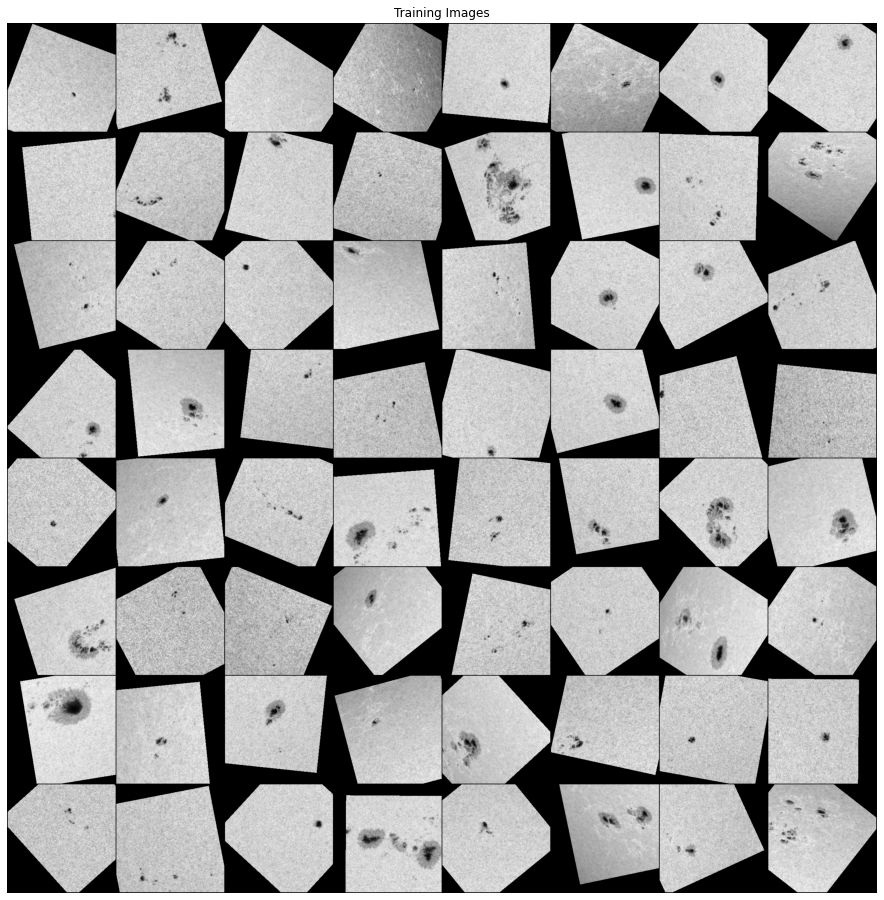

In [21]:
from utils import glance_data # import the helper function
# Lets look at what the network receives during training by passing the training generator to the function
glance_data(train_generator)

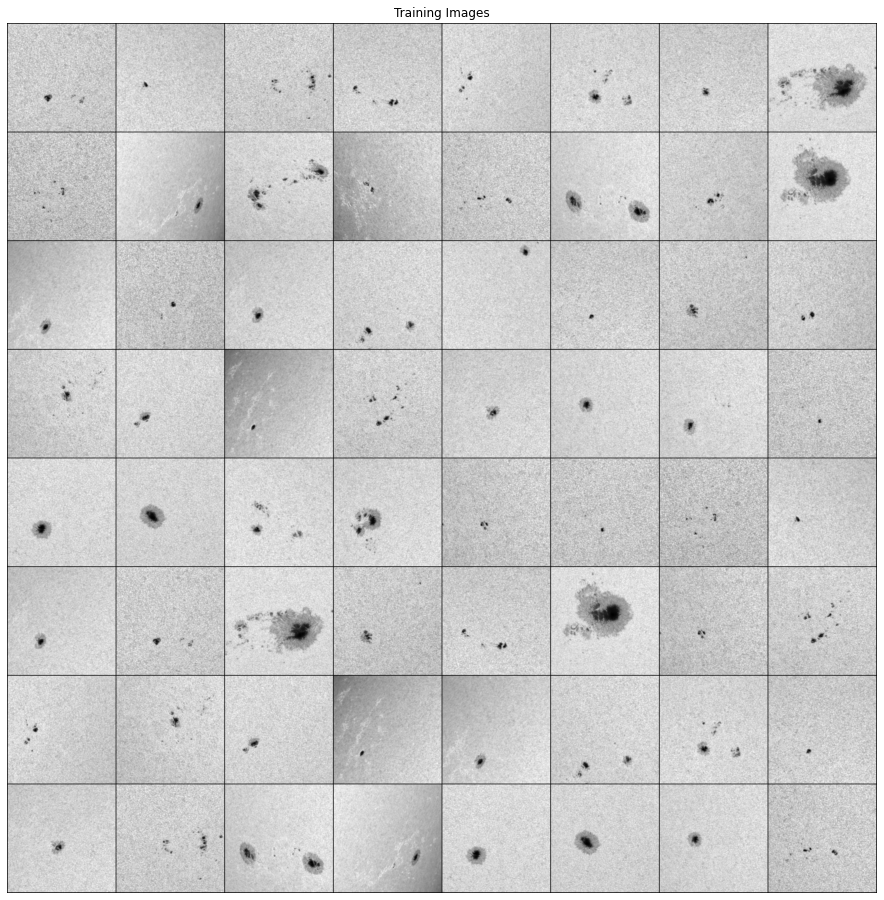

In [22]:
# and here are the images the network is tested on
glance_data(validation_generator)

We will use a predefined model called EfficientNetB0, for details of the architecture see the [paper](https://arxiv.org/pdf/1905.11946.pdf). For details about the network settings used below see the [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0)

In [4]:
model = tf.keras.applications.efficientnet.EfficientNetB0(
    weights=None, # This means we want to randomly initiate the weights and not use pre-trained weights
    include_top=True, # Include the dense layer after the convolutions since we need to make binary predictions
    input_tensor=tf.keras.layers.Input(shape=(img_height,img_width,1)), # define the input shape, i.e., 300*300 greyscale images
    classes=2, # sunspots and pores
    classifier_activation=None # means the network will return logits since it has no final activation function   
)

In [5]:
import os
from tensorflow import keras # we use optimizers from keras

# Tell the model how to optimize its parameters
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), # We use the popular Adam optimizer for gradient descent
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), # since we have the raw output not passed through a softmax function
    metrics=['accuracy']  # We want to monitor the models accuracy during training 
)

# create a callback that saves the model weights for each epoch encase the best model is not the last model
# alternatively you could also only keep the model that performes the best on the validation set
checkpoint_path = "saved_weights/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=0, 
    save_weights_only=True,
    save_freq='epoch')
# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

batch_size = 10
# fit the model to the data
history = model.fit(
    train_generator, # feeds in batches of processed/augmented images 
                     # the model knows the labels because the images were placed into two folders according to their class
    epochs=500, # We amount of times the network will see the entire training set 
    steps_per_epoch=152/batch_size, # generators will keep creating data so we need to tell them when an epoch is over
    validation_data=validation_generator, # feed in batches of un-augmented data from the validation set 
    validation_steps=37/batch_size,
    callbacks=[cp_callback],
    verbose=0 # verbose 0 --> silent 1 --> progress bar
)

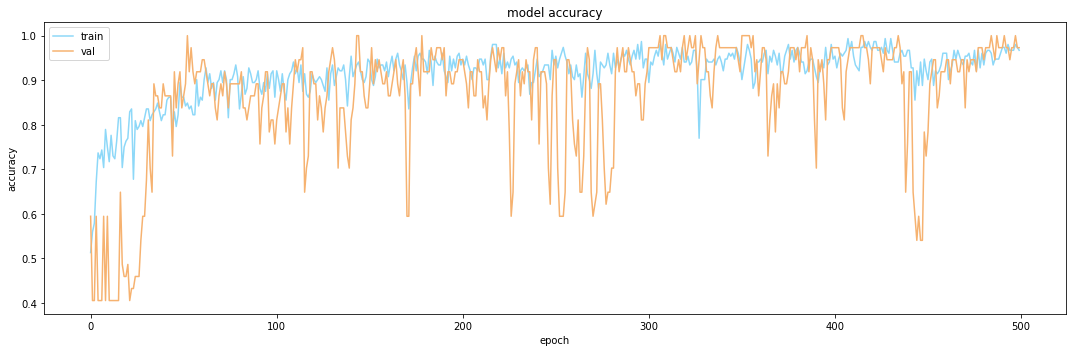

In [31]:
# We now see how the training went by monitoring the learning curve (accuracy and loss)
# we want the model with the highest accuracy on the validation set
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(history.history['accuracy'], c='#8dd8f8')
plt.plot(history.history['val_accuracy'],  c='#f6b270')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [32]:
# Evaluate the model on the test data
results = model.evaluate(validation_generator, batch_size=20)
print("test loss, test acc:", results)

4/4 [==============================] - 1s 145ms/step - loss: 0.1190 - accuracy: 0.9730
test loss, test acc: [0.11900760233402252, 0.9729729890823364]


### <font color='dodgerblue'>Grad-CAM</font>   
We now apply Grad-CAM to our trained model to see what parts of the images it is basing it decisions on  

In [6]:
import os
import numpy as np
from IPython.display import Image, display # for grad-cam image
from matplotlib.image import imread # for converting .jpg or .png images into numpy arrays
import cv2 # for grad-cam image
import matplotlib as mpl # for cmaps
import matplotlib.cm as cm # for cmaps

In [7]:
def get_img_array(img_path):
    array = imread(img_path)
    # We add a dimension to transform our array into (1, 300, 300, 1)
    array = np.expand_dims(array, axis=0)
    array = np.expand_dims(array, axis=-1)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, obs_name="obs.jpg", alpha=0.4, save_dir='save_root'):
    # Load the original image
    img = cv2.imread(img_path)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    save_dir = f'{save_root}{obs_name}'
    superimposed_img.save(save_dir)
    

def make_high_res_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = keras.preprocessing.image.array_to_img(heatmap)
    heatmap = heatmap.resize((img_array.shape[1], img_array.shape[2]))
    heatmap = np.array(heatmap)
    
    return heatmap

In [8]:
# restore the optimal model weights saved from the callback
model.load_weights('./optimal_weights/cp-0443.ckpt');

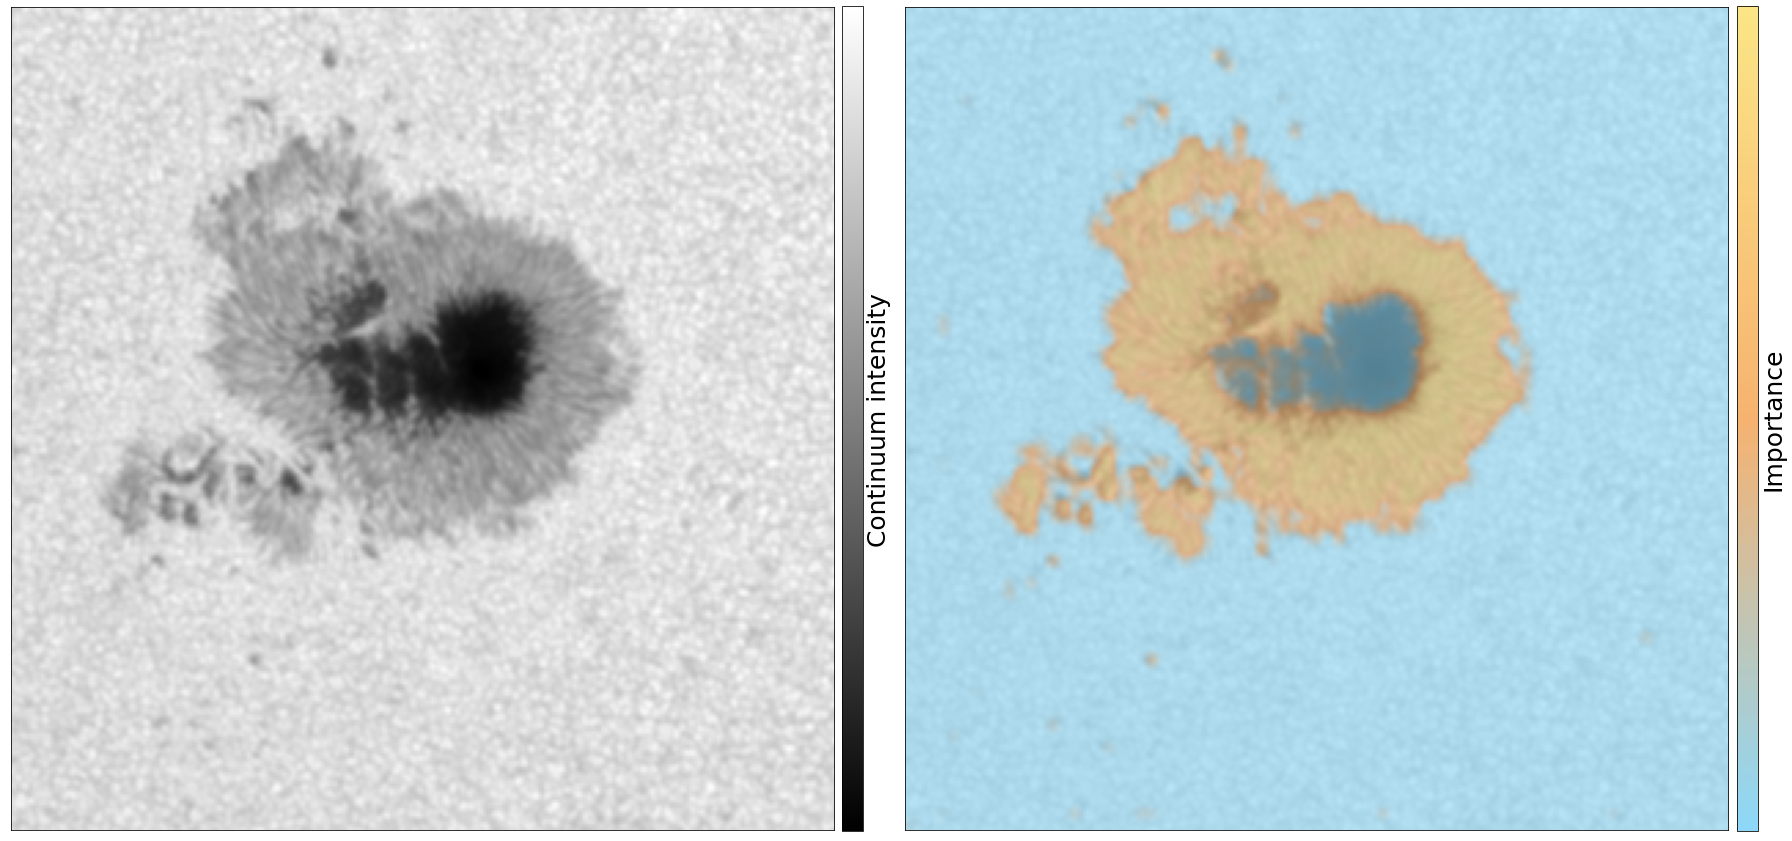

In [16]:
# plot Grad-CAM results for a single input image of a Sunspot

# create custome color map
from matplotlib.colors import LinearSegmentedColormap
colors = [(141/255,216/255,248/255), (246/255, 178/255, 112/255), (251/255, 229/255, 134/255)]
cm = LinearSegmentedColormap.from_list('my_cmap', colors, N=100)
colors = cm(np.linspace(0,1,15))

# select observation to perform Grad-CAM on
obs = '2020-11-28T115853x1400y1300_sp'
path = f'./data/spot_jpg/{obs}.jpg'

# collect image corresponding to the observation and put into correct format
im = get_img_array(path)
imm = im.copy()
imm = np.expand_dims(imm,axis=0)
imm = np.expand_dims(imm,axis=-1)

# select the final convolutional layer by name and calculate the heatmap using Grad-CAM
last_conv_layer_name = 'block2a_dwconv'
heatmap = make_high_res_gradcam_heatmap(im, model, last_conv_layer_name)

# plot figure
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,25))
# the original continuum image for refrance
ax1.imshow(np.squeeze(imm), cmap='binary_r')
ax1.set_xticks([])
ax1.set_yticks([])
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap='binary_r'),orientation='vertical',pad=0.01,fraction=0.0242,aspect=40, ax=ax1)
cbar.set_label('Continuum intensity', fontsize=25)
cbar.set_ticks([])

# the attention map from Grad-CAM overlayed
ax2.imshow(np.squeeze(imm), cmap='binary_r')
plt.imshow(heatmap, cmap=cm, alpha=.6)
ax2.set_xticks([])
ax2.set_yticks([])
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cm),orientation='vertical',pad=0.01,fraction=0.0242,aspect=40)
cbar.set_label('Importance', fontsize=25)
cbar.set_ticks([])
plt.tight_layout()
plt.show()
plt.close(fig)

The network has leaned to focus its attention on the penumbra (orange), since this is the determining factor that separates pores from Sunspots 